Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook. [ref](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import

We import all the necessary packages. We are going to work with `fastai 1.0.5x` which sits on top of `pytorch 1.x`, and opencv-python.

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import SaveModelCallback
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re, os
import random
import fastai

In [3]:
fastai.__version__

'1.0.59'

# Preprocess

Let's find our raw images and manually labelled masks.

In [4]:
raw_dir = Path("raw")

raws = [raw_path for raw_path in raw_dir.ls() if ".tif" in raw_path.as_posix()]
labels = sorted([raw_path for raw_path in raws if "_label" in raw_path.name])
images = [Path(re.sub(r'_label', '_image', raw_path.as_posix())) for raw_path in labels]

In [5]:
for label,image in zip(labels,images):
    print(label, image)

raw/AIDOXNTDT_14_SO_10_Z0020_label.tif raw/AIDOXNTDT_14_SO_10_Z0020_image.tif
raw/AIDOXNTDT_14_SO_10_Z0268_label.tif raw/AIDOXNTDT_14_SO_10_Z0268_image.tif


Megan labelled 672\*448px sized images, but we need to train fastai's resnet34 model on 224*224px sized images so let's cut them up.

In [6]:
processed_dir = Path("processed")
# for f in processed_dir.ls(): os.remove(f)
l=224

In [7]:
from tqdm import tqdm
empty_tile = 0
populated_tile= 0

for image_path,label_path in tqdm(zip(images,labels)):
    image = cv.imread(image_path.as_posix(), cv.COLOR_BGR2GRAY)
    label = cv.imread(label_path.as_posix(), cv.COLOR_BGR2GRAY)

    if image.shape != label.shape:
        raise ValueError(image_path.as_posix() + label_path.as_posix())
    i_max = image.shape[0]//l
    j_max = image.shape[1]//l

# If the cells were labelled as 255, or something else mistakenly, instead of 1.
    label[label!=0]=1

    for i in range(i_max):
        for j in range(j_max):
            cropped_image = image[l*i:l*(i+1), l*j:l*(j+1)]
            cropped_label = label[l*i:l*(i+1), l*j:l*(j+1)]
            
            if (cropped_label!=0).any():
                populated_tile+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            else:
                empty_tile+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + label_path.suffix)
 
            cv.imwrite(cropped_image_path.as_posix(), cropped_image)
            cv.imwrite(cropped_label_path.as_posix(), cropped_label)

2it [00:00,  1.92it/s]


In [8]:
f"There are {populated_tile} tiles with cells in them, and {empty_tile} empty tiles."

'There are 12 tiles with cells in them, and 0 empty tiles.'

# fastAI

**NB:** From here onwards we will train the fastAI model. This process is very well documented in their [part 1](https://course.fast.ai/videos/?lesson=1) of their lecture series and I highly recommend you watch it.

## Databunch

fastai offers a well documented [image transformation library](https://docs.fast.ai/vision.transform.html) written from scratch in PyTorch.

In [9]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1, #consider
    max_rotate = 0,
    max_lighting = None,
    max_warp = None,
    p_affine = 0.75,
    p_lighting = 0.75)

We use fastAI's [data block API](https://docs.fast.ai/data_block.html) to load our preprocessed data from above.

In [10]:
get_label_from_image = lambda path: re.sub(r'_image_', '_label_', path.as_posix())
codes = ["NOT-CELL", "CELL"]

bs = 9

src = (
    SegmentationItemList.from_folder(processed_dir)
    .filter_by_func(lambda fname:'image' in Path(fname).name)
    .split_by_rand_pct(valid_pct=0.25, seed=2)
    .label_from_func(get_label_from_image, classes=codes)
)
data = (
    src.transform(transforms, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [11]:
data

ImageDataBunch;

Train: LabelList (9 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: processed;

Valid: LabelList (3 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: processed;

Test: None

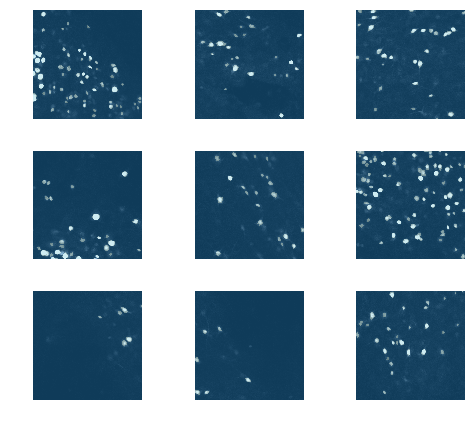

In [12]:
data.show_batch(rows=3, figsize=(7,6))

# Training

In [13]:
learn = unet_learner(
    data,
    models.resnet34,
    metrics=partial(dice, iou=True),
    model_dir='..')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/nzxwang/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.9MB/s]


find the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.58E-03


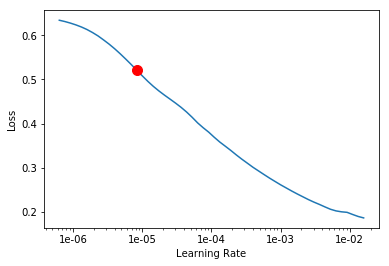

In [14]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [15]:
lr = 5e-04
learn.fit_one_cycle(cyc_len = 20,
                    callbacks =[SaveModelCallback(
                        learn,
                        every='improvement',
                        monitor = 'dice',
                        name='best-stage1')],
                    max_lr = lr)

epoch,train_loss,valid_loss,dice,time
0,0.652536,0.511183,0.004978,00:03
1,0.519298,0.521238,0.002165,00:00
2,0.435572,0.771106,0.000522,00:00
3,0.404801,0.232519,0.035012,00:00
4,0.336034,0.874609,0.088372,00:00
5,0.386560,0.969147,0.000193,00:00
6,0.403044,0.455170,0.000559,00:00
7,0.388188,0.192648,0.013931,00:00
8,0.357419,0.100741,0.276311,00:00
9,0.324681,0.100446,0.571258,00:00


Better model found at epoch 0 with dice value: 0.004978411830961704.
Better model found at epoch 3 with dice value: 0.03501177951693535.
Better model found at epoch 4 with dice value: 0.08837229013442993.
Better model found at epoch 8 with dice value: 0.2763107120990753.
Better model found at epoch 9 with dice value: 0.5712584853172302.
Better model found at epoch 10 with dice value: 0.6990602016448975.


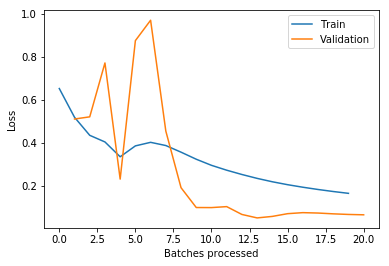

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.load("best-stage1");

In [18]:
learn.unfreeze()

In [19]:
lrs = slice(lr/1000,lr/10)

In [20]:
learn.fit_one_cycle(cyc_len = 12,
                    max_lr = lrs,
                    pct_start = 0.8,
                    callbacks =[SaveModelCallback(
                        learn,
                        every='improvement',
                        monitor = 'dice',
                        name='best-stage2')])

epoch,train_loss,valid_loss,dice,time
0,0.053848,0.098520,0.699666,00:00
1,0.052720,0.090654,0.698253,00:00
2,0.051651,0.079782,0.694111,00:00
3,0.049767,0.067548,0.682186,00:00
4,0.047273,0.057843,0.652284,00:00
5,0.044550,0.054049,0.614436,00:00
6,0.042402,0.056777,0.567479,00:00
7,0.040913,0.061561,0.535657,00:00
8,0.040133,0.061623,0.539565,00:00
9,0.039437,0.056450,0.575493,00:00


Better model found at epoch 0 with dice value: 0.6996657252311707.


In [21]:
learn.export(file = "../training_example.pkl")